In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from RobotSim373 import *

Version:  0.0.16


In [12]:
def build(robot):    
    
    left=Box(robot,2,12,width=1,height=1,name='left')
    right=Box(robot,2,10,width=1,height=1,name='right')
    center=Disk(robot,2,11,radius=0.3,name='center')
    
    connect(left,right,'weld')  # revolves around the middle of the second object
    connect(left,center,'weld')  # revolves around the middle of the second object
    connect(right,center,'weld')  # revolves around the middle of the second object


In [13]:
def turn_a_bit(t,robot):
    
    robot.message = 'turn'
    if t<0.9:
        robot['left'].F=-10
        robot['right'].F=10
        return False        # not done yet!
    else:
        return True        #  done with this behavior
    
    
def turn_to_min_distance(t,robot):
    robot.message = 'min distance'
    
    d=robot['left'].read_distance()
    if d<robot.last_distance:
        robot['left'].F=-10
        robot['right'].F=10
        robot.last_distance=d
        return False
    else:
        return True

def forward(t,robot):
    robot.message = 'forward'
    robot['left'].F=10
    robot['right'].F=10
    return True
    
def stop(t,robot):
    robot.message = 'stop'
    robot['left'].F=0
    robot['right'].F=0
    
    return True 
    
def wait(dt):
    
    def _wait(t,robot):
        if t<dt:
            return False
        else:
            return True
        
    return _wait
    
    
def monitor(t,robot):
    robot.storage+=t,robot['left'].read_distance()
    current_state=robot.controller.current_state
    if 'wait' not in current_state:
        robot.message=robot.controller.current_state

In [14]:
stopwait=StateMachine(
    {
    'stop':(stop,'wait1'),
    'wait1':(wait(2),'forward'),
    'forward':(forward,'wait2'),
    'wait2':(wait(2),'stop')
    },
    first_state='stop')

state_machine=StateMachine(
    {
     'turn a bit':(turn_a_bit,'turn to minimum'),
     'turn to minimum':(turn_to_min_distance,stopwait),   
    },
    first_state='turn a bit')


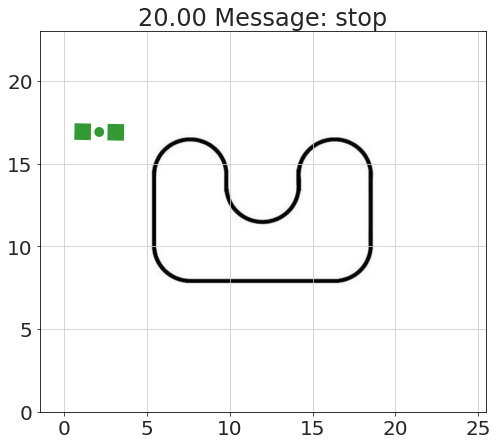

In [15]:
env=Environment(image='images/linepath1.jpeg',linearDamping=20) 
robot=Robot(env)

build(robot)
robot.last_distance=500

robot.controller=Controller(robot,state_machine)
robot.controller.monitor=monitor


run_sim(env,robot.controller,
        total_time=20,  # seconds
        dt=1/60,
        dt_display=.2,  # make this larger for a faster display
        figure_width=8,
        plot_orientation=False,
       )    

## Adding another behavior

In [32]:
def stop(t,robot):
    robot.message = 'stop'
    robot['left'].F=0
    robot['right'].F=0
    robot['center'].τ=0
    
    return True 

def straighten(t,robot):
    robot.message = 'straighten'
    dl=robot['left'].read_distance()
    dr=robot['right'].read_distance()
    if dl<dr:
        robot['center'].τ=5
    else:
        robot['center'].τ=-5
        
    return False


In [35]:
stopwait=StateMachine(
    {
    'stop':(stop,'wait1'),
    'wait1':(wait(2),'forward'),
    'forward':(forward,'straighten2'),
    'straighten2':([straighten,wait(2)],'stop')  # if either one exits with True, then the next state is done
    },
    first_state='stop')

state_machine=StateMachine(
    {
     'turn a bit':(turn_a_bit,stopwait),
    },
    first_state='turn a bit')


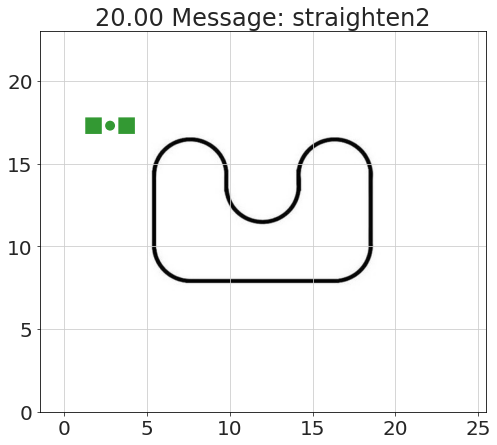

In [36]:
env=Environment(image='images/linepath1.jpeg',linearDamping=20) 
robot=Robot(env)

build(robot)
robot.last_distance=500

robot.controller=Controller(robot,state_machine)
robot.controller.monitor=monitor


run_sim(env,robot.controller,
        total_time=20,  # seconds
        dt=1/60,
        dt_display=.2,  # make this larger for a faster display
        figure_width=8,
        plot_orientation=False,
       )    